In [1]:
import re
import spacy
from spacy.lang.pl.stop_words import STOP_WORDS
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from pandas import read_csv
import pandas as np
from sklearn.model_selection import train_test_split


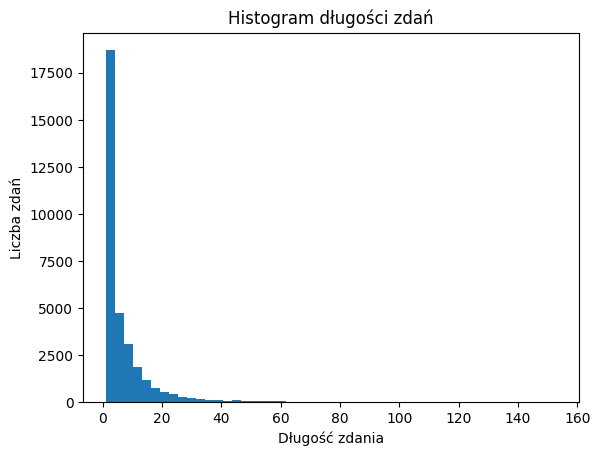

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Wczytanie pliku CSV
df = pd.read_csv('csv_data/preprocesed_files/normal_opinions.csv', sep=',')

# Pobranie zawartości kolumny "content" jako listy zdań
sentences = df['content'].tolist()

# Obliczenie długości każdego zdania
sentence_lengths = [len(sentence.split()) for sentence in sentences]

# Wyświetlenie histogramu
plt.hist(sentence_lengths, bins=50)
plt.xlabel('Długość zdania')
# plt.xlim(0, 50)  # Ograniczenie osi x do zakresu od 0 do 50
plt.ylabel('Liczba zdań')
plt.title('Histogram długości zdań')
plt.show()


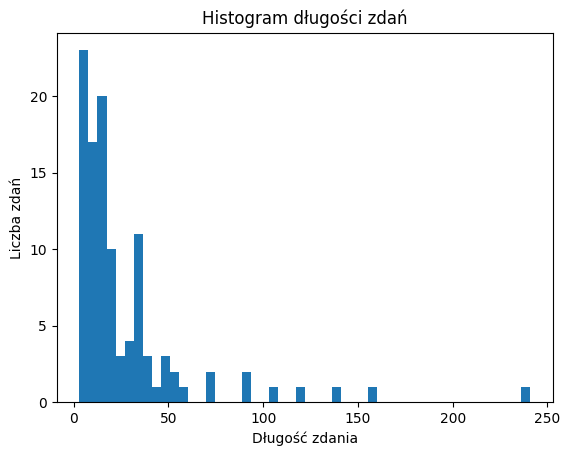

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Wczytanie pliku CSV
df = pd.read_csv('csv_data/preprocesed_files/anomaly_opinions.csv', sep=',')

# Pobranie zawartości kolumny "content" jako listy zdań
sentences = df['content'].tolist()

# Obliczenie długości każdego zdania
sentence_lengths = [len(sentence.split()) for sentence in sentences]

# Wyświetlenie histogramu
plt.hist(sentence_lengths, bins=50)
plt.xlabel('Długość zdania')
# plt.xlim(0, 50)  # Ograniczenie osi x do zakresu od 0 do 50
plt.ylabel('Liczba zdań')
plt.title('Histogram długości zdań')
plt.show()


In [4]:
# Wczytanie danych
anomaly_opinions = read_csv('csv_data/preprocesed_files/anomaly_opinions.csv', sep=',')
normal_opinions = read_csv('csv_data/preprocesed_files/normal_opinions.csv', sep=',')
anomaly_opinions = anomaly_opinions["content"].values.tolist()
normal_opinions = normal_opinions["content"].values.tolist()

#Podział normalnych opinii na część testową i treningowa, liczba normalnych opinii 12 936,do treningu wykorzystano 90%
normal_opinions, normal_opinions_test = train_test_split(normal_opinions, test_size = 0.2)  


print("Wykorzystane normalne opinie: ", len(normal_opinions))
print("Wykorzystane anomalie: ", len(anomaly_opinions))


Wykorzystane normalne opinie:  26472
Wykorzystane anomalie:  107


In [ ]:
# Inicjalizacja modelu spaCy
nlp = spacy.load('pl_core_news_md')
nlp.pipe_names


In [ ]:
#Upraszczanie opini przed dodaniem do DataSet (lower case, tylko litery)
def preprocess_review(review):
    # Usunięcie niepotrzebnych znaków
    cleaned_review = re.sub(r'[^a-zA-ZąćęłńóśźżĄĆĘŁŃÓŚŹŻ\s]', '', review)
    # Tokenizacja tekstu
    cleaned_review = cleaned_review.lower()
    return cleaned_review

In [ ]:
def tensor_preprocessing(token_list):
    sequence = np.array([token.vector for token in token_list])
    sequence = torch.tensor(sequence, dtype=torch.float32)
    print(type(sequence))

    print(sequence.size())
    return sequence

In [ ]:
def token_preprocessing(opinion):
    token_list = []
    doc = nlp(preprocess_review(opinion))
    for token in doc:
        #TODO: Check if neccesary.
        if not token.is_stop:
            #TODO:
            #token_list.append(token.lemma)
            token_list.append(token)
    return token_list


In [ ]:
def preprocessing_pipeline(review):
    token_list = token_preprocessing(review)
    sequence = tensor_preprocessing(token_list)
    # Normalizacja wektorów
    #sequence = nn.functional.normalize(sequence, p=1, dim=1)
    return sequence

In [ ]:
# Klasa Dataset do przechowywania danych opinii
class OpinionDataset(Dataset):
    def __init__(self, opinions):
        self.opinions = opinions

    def __len__(self):
        return len(self.opinions)

    #Metoda get_item bierze pojedyńczą opinie wykonuje na niej preprocess_review, następnie wykorzystuję metode nlp z biblioteki Spacy
    #do tokenizacji. Następnie wyciąga wektor word embeddings po tokenizacji i z jego wykorzystaniem tworzy tensor. Ostatnim korkiem
    #jest normalizacja tensora z wykorzystaniem normalizacji norma L1 (Manhattan norm)
    def __getitem__(self, idx):
        return self.opinions[idx]


In [ ]:
# Tworzenie datasetów dla danych normalnych treningowych, testowych i opinii o podwójnej jakości
normal_dataset = OpinionDataset(normal_opinions)
anomalous_dataset = OpinionDataset(anomaly_opinions)
normal_test_dataset = OpinionDataset(normal_opinions_test)

# Wyliczenie maksymalnego rozmiaru sekwencji wektorów
max_seq_len1 = max(len(opinion) for opinion in normal_dataset.opinions)
max_seq_len2 = max(len(opinion) for opinion in anomalous_dataset.opinions)
max_seq_len3 = max(len(opinion) for opinion in normal_test_dataset.opinions)
max_seq_len = max(max_seq_len1, max_seq_len2, max_seq_len3)
print("Maksymalna długość opinii: ",max_seq_len)


In [ ]:
#TODO: DLACZEGO TO MA TAKI SIZE

print(normal_dataset[0])
print(len(normal_dataset[0]))
preprocessing_pipeline(normal_dataset[0])

In [ ]:
# Wyrównanie rozmiarów sekwencji wektorów
def pad_sequence(sequence, max_len):
    if sequence.size(0) == 0:
        return torch.zeros(max_len, 300)
    else:
        padded_seq = torch.zeros(max_len, sequence.size(1))
        padded_seq[:sequence.size(0)] = sequence
        return padded_seq

In [ ]:
# Dostosowanie sekwencji wektorów do maksymalnego rozmiaru
normal_dataset = [pad_sequence(preprocessing_pipeline(opinion), max_seq_len) for opinion in normal_dataset]
anomalous_dataset = [pad_sequence(preprocessing_pipeline(opinion), max_seq_len) for opinion in anomalous_dataset]
normal_dataset_test = [pad_sequence(preprocessing_pipeline(opinion), max_seq_len) for opinion in normal_test_dataset]


In [ ]:
# Definicja autoenkodera
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, input_dim // 2),
            nn.ReLU(),
            nn.Linear(input_dim // 2, input_dim // 4),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(input_dim // 4, input_dim // 2),
            nn.ReLU(),
            nn.Linear(input_dim // 2, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [57]:
input_dim

300

In [ ]:
# Wielkość wejściowa
input_dim = normal_dataset[0].size(1)

# Inicjalizacja modelu autoenkodera
autoencoder = Autoencoder(input_dim)

# Definicja funkcji straty i optymalizatora
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.0001)

# Inicjalizacja pustej macierzy pomyłek
cm = torch.zeros((2, 2), dtype=torch.int)

In [ ]:
# Funkcja obliczająca próg na podstawie kwantyla
def calc_threshold(values, quantile):
    return torch.quantile(values, quantile)


# Funkcja trenująca autoenkodera
def train_autoencoder(model, dataloader, criterion, optimizer, quantile, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch in dataloader:
            optimizer.zero_grad()
            inputs = batch.float()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Obliczanie macierzy pomyłek
            with torch.no_grad():
                autoencoder.eval()
                mse_loss = nn.MSELoss(reduction='none')
                loss_values = mse_loss(outputs, inputs).mean(dim=(1, 2))
                is_anomalous = torch.where(loss_values > calc_threshold(loss_values, quantile), 1, 0)

                for label in is_anomalous:
                    cm[label][label] += 1

        epoch_loss = running_loss / len(dataloader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    return calc_threshold(loss_values, quantile)

In [ ]:
# Tworzenie DataLoader dla danych normalnych
normal_dataloader = DataLoader(normal_dataset, batch_size=32, shuffle=True)

# Ustal wartość kwantyla
quantile = 0.87

# Trenowanie autoenkodera
threshold = train_autoencoder(autoencoder, normal_dataloader, criterion, optimizer, quantile, num_epochs=10)
print("Wyznaczony próg: ", threshold.real)
print("")

# Wyświetlanie macierzy pomyłek
print("Macierz pomyłek:")
print(cm)

In [ ]:
# Inicializacja macierzy cm
cm = torch.zeros((2, 2), dtype=torch.int)

# Testowanie na opiniach nieświadczących o podwójnej jakości
with torch.no_grad():
    autoencoder.eval()
    for batch in DataLoader(normal_dataset_test, batch_size=1):
        inputs = batch.float()
        outputs = autoencoder(inputs)
        mse_loss = nn.MSELoss(reduction='none')
        loss_values = mse_loss(outputs, inputs).mean(dim=(1, 2))
        is_anomalous = torch.where(loss_values > threshold, 1, 0)
        cm[0][is_anomalous] += 1

In [ ]:
# Testowanie na opiniach świadczących o podwójnej jakości
with torch.no_grad():
    autoencoder.eval()
    for batch in DataLoader(anomalous_dataset, batch_size=1):
        inputs = batch.float()
        outputs = autoencoder(inputs)
        mse_loss = nn.MSELoss(reduction='none')
        loss_values = mse_loss(outputs, inputs).mean(dim=(1, 2))
        print(loss_values)
        is_anomalous = torch.where(loss_values > threshold, 1, 0)
        cm[1][is_anomalous] += 1

# Obliczenie sumy wierszy i kolumn macierzy pomyłek
sum_rows = torch.sum(cm, dim=1)
sum_cols = torch.sum(cm, dim=0)

# Obliczenie liczby prawdziwie negatywnych, fałszywie negatywnych, fałszywie pozytywnych i prawdziwie pozytywnych
tn = cm[0][0]
fn = cm[0][1]
fp = cm[1][0]
tp = cm[1][1]

# Wyświetlenie macierzy pomyłek
print("Macierz pomyłek:")
print(cm)
print()

# Wyświetlenie innych metryk oceny
print("Liczba prawdziwie negatywnych (TN):", tn.item())
print("Liczba fałszywie negatywnych (FN):", fn.item())
print("Liczba fałszywie pozytywnych (FP):", fp.item())
print("Liczba prawdziwie pozytywnych (TP):", tp.item())
print()

accuracy = (tn + tp) / (tn + fn + fp + tp)
print("Accuracy:", accuracy.item())

precision = tp / (tp + fp)
print("Precision:", precision.item())

recall = tp / (tp + fn)
print("Recall:", recall.item())

f1_score = 2 * (precision * recall) / (precision + recall)
print("F1-Score:", f1_score.item())

In [ ]:
import torch
import torch.nn as nn

# Przygotuj tekst testowy
text = "mój polski proszek jest gorszy niż niemiecki niż"


preprocessed_text = pad_sequence(preprocessing_pipeline(text), max_seq_len)


# Przekonwertuj przetworzony tekst na tensor PyTorch
test_data = torch.Tensor(preprocessed_text)

# Przekaż dane testowe przez model
decoded_data = autoencoder(test_data)

# Testowanie na opiniach nieświadczących o podwójnej jakości
with torch.no_grad():
    autoencoder.eval()
    
    inputs = test_data
    outputs = autoencoder(inputs)
    mse_loss = nn.MSELoss(reduction='none')
    loss_values = mse_loss(outputs, inputs).mean()
    print(loss_values)
    is_anomalous = torch.where(loss_values > threshold, 1, 0)
    print(is_anomalous)
